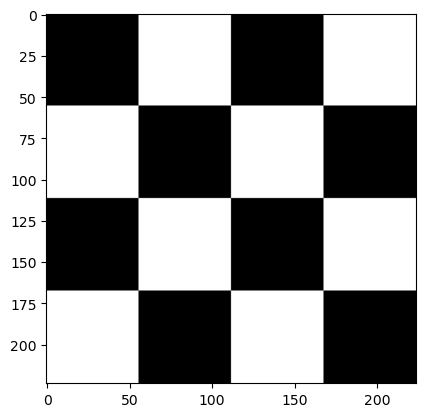

In [1]:
import numpy as np

def generate_tile(light=(255, 255, 255), dark=(0, 0, 0)):
  row = [0] * 56 + [1] * 56
  row *= 2
  tile = [row for _ in range(56)]
  anti_row = [1 - b for b in row]
  anti_tile = [anti_row for _ in range(56)]
  tile.extend(anti_tile)
  tile *= 2
  tile = np.array(tile, dtype=np.uint8)
  light = np.array(light, dtype=np.uint8)
  dark = np.array(dark, dtype=np.uint8)
  tile = np.expand_dims(tile, 0)
  light = np.expand_dims(light, (1, 2))
  dark = np.expand_dims(dark, (1, 2))
  return (1 - tile) * dark + tile * light

import matplotlib.pyplot as plt
import torch

tile = generate_tile()
torch_tile = torch.Tensor(tile).to(device=torch.device('cuda'), dtype=torch.uint8)
plt.imshow(torch_tile.permute(1, 2, 0).cpu())

In [2]:
torch_tile.shape

torch.Size([3, 224, 224])

In [3]:
row = 4
col = 4
batch_size = row * col
batch = torch.tile(torch_tile, (batch_size, 1, 1, 1))
batch.shape

torch.Size([16, 3, 224, 224])

In [4]:
from transforms import RandAugment17
from torchvision.transforms import v2
import torchvision.datasets as datasets

In [5]:
randaug = RandAugment17(1, 10, num_magnitude_bins=11, fill=[128] * 3)

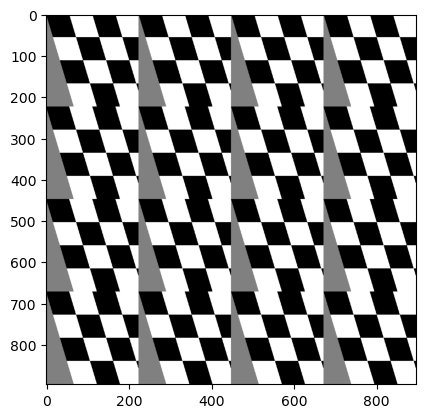

In [6]:
transformed = randaug(batch)

out = torch.cat([torch.cat([transformed[r * col + c] for c in range(col)], dim=2) for r in range(row)], dim=1)

plt.imshow(out.permute(1, 2, 0).cpu())

In [7]:
input_resolution = 224
data = "/data/ImageNet/"
transform = [
    v2.ToImage(),
    v2.RandomResizedCrop(input_resolution, scale=(0.05, 1.0)),
    v2.RandomHorizontalFlip(),
    randaug,
]
train_dataset = datasets.ImageNet(data, split='train', transform=v2.Compose(transform))
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False,
)

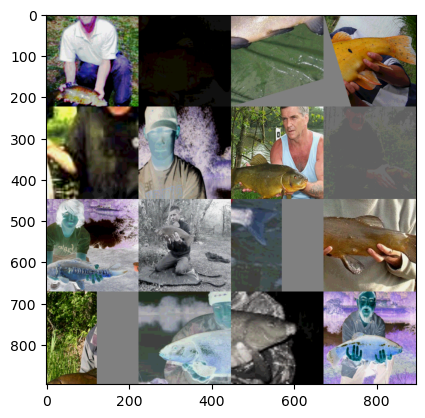

In [8]:
batch, _ = next(iter(train_loader))
transformed = randaug(batch)

out = torch.cat([torch.cat([transformed[r * col + c] for c in range(col)], dim=2) for r in range(row)], dim=1)

plt.imshow(out.permute(1, 2, 0))

Note that while v2 transforms support both CUDA and batched images, batched input results in transforms randomized *per batch* instead of *per example* for randomized transforms like randaug. So even if dataloader workers can't keep up with the GPU, there is little to gain to move randomized augmentations to GPU without compromising how augmentations are done.